<a href="https://colab.research.google.com/github/davione112/HateSpeechDetection/blob/main/Hate_speech_detection_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install emot --upgrade
!pip install regex
!pip install pyvi
# !pip install vncorenlp
# !pip install datasets
# !pip install torch
# !pip install transformers==4.9.2
# !pip install deplacy vncorenlp
# !test -d VnCoreNLP || git clone --depth=1 https://github.com/vncorenlp/VnCoreNLP

In [ ]:
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
# from transformers import BertTokenizer, BertModel,Trainer, TrainingArguments,AutoModelForSequenceClassification,DataCollatorWithPadding
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# from transformers.trainer_callback import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from itertools import groupby
import torch
import regex as re
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO 
# from vncorenlp import VnCoreNLP
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from pyvi import ViTokenizer, ViPosTagger,ViUtils
from sklearn.linear_model import LogisticRegression
# vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 
from sklearn.model_selection import train_test_split
import joblib
from sklearn import preprocessing
from sklearn import preprocessing
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%cd /content/drive/MyDrive/hate_speech_detection

/content/drive/.shortcut-targets-by-id/15esFt6mWnsxUBQ_vxIcTDi0kv6Nx3Brk/hate_speech_detection


#Data Loader

In [ ]:
train = pd.read_csv("vihsd/vihsd/train.csv",index_col=False)
test = pd.read_csv("vihsd/vihsd/test.csv",index_col=False)
dev = pd.read_csv("vihsd/vihsd/dev.csv",index_col=False)

In [ ]:
train.head(5)

,free_text,label_id
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2
2,Đậu Văn Cường giờ giống thằng sida hơn à,0
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0


#Overview

In [ ]:
print(train.shape,dev.shape,test.shape)

(24048, 2) (2672, 2) (6680, 2)


## Remove duplicate

In [ ]:
dev = dev.drop_duplicates(keep='last').reset_index(drop=True)
train = train.drop_duplicates(keep='last').reset_index(drop=True)
print(train.shape,dev.shape,test.shape)

(22692, 2) (2651, 2) (6680, 2)


##Remove missing values

In [ ]:
train = train.dropna().reset_index(drop=True)
dev = dev.dropna().reset_index(drop=True)
print(train.shape,dev.shape,test.shape)

(22690, 2) (2651, 2) (6680, 2)


##Count label

In [ ]:
def count_label(dataset):
  count = (train['label_id'].value_counts())
  sns.set()
  # labels = data.keys()
  count.plot(kind='pie', title='Number of label in training set', figsize=[8,8], startangle=90, shadow=True,
             colors=['#EAB315','#F1CB5F','#F7E4AF'],
          autopct=lambda p: '{:.2f}%({:.0f})'.format(p,(p/100)*count.sum()))
  plt.show()

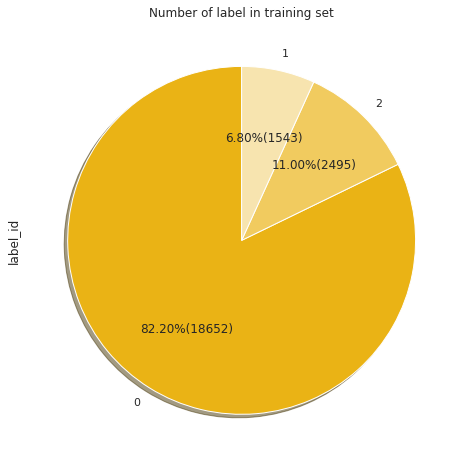

In [ ]:
count_label(train)

##Length of comment

In [ ]:
def length(dataset):
  l = []
  for i in train['free_text']:
    l.append(len(str(i).split()))
  l = pd.DataFrame(l, columns=['Length'])  
  l = (l.value_counts())
  sns.set()
  l.plot(kind='area', title='Length of comments in training set', figsize=[8,8], colormap='summer',
          )
  plt.show()

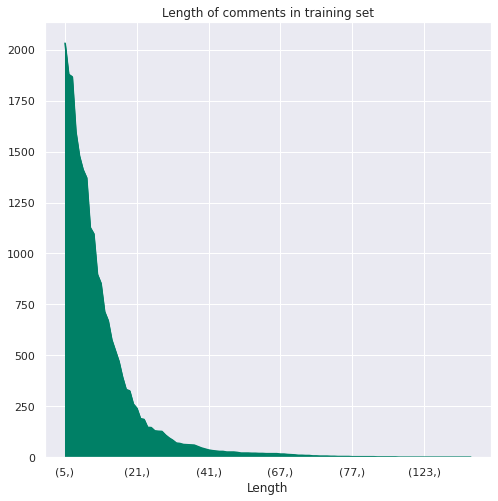

In [ ]:
length(train)

##Vocab

In [ ]:
def create_vocab(dataset):
  text = []
  for sentence in dataset['free_text']:
    text.extend(str(sentence).split())
  vocab = set(text)
  # print(groupby(text))
  #print(len(vocab),vocab)
  df = pd.DataFrame(list(vocab))
  return df

In [ ]:
text = []
for sentence in train['free_text']:
  text.extend(str(sentence).split())

In [ ]:
vocab = create_vocab(train)
vocab.to_csv('vocab.csv')

#Preprocessing

##Normalize Unicode

In [ ]:
"""
    Start section: Chuyển câu văn về kiểu gõ telex khi không bật Unikey
    Ví dụ: thủy = thuyr, tượng = tuwowngj
"""
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)


def vn_word_to_telex_type(word):
    dau_cau = 0
    new_word = ''
    for char in word:
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            new_word += char
            continue
        if y != 0:
            dau_cau = y
        new_word += bang_nguyen_am[x][-1]
    new_word += bang_ky_tu_dau[dau_cau]
    return new_word


def vn_sentence_to_telex_type(sentence):
    """
    Chuyển câu tiếng việt có dấu về kiểu gõ telex.
    :param sentence:
    :return:
    """
    words = sentence.split()
    for index, word in enumerate(words):
        words[index] = vn_word_to_telex_type(word)
    return ' '.join(words)


"""
    End section: Chuyển câu văn về kiểu gõ telex khi không bật Unikey
"""
# vn_sentence_to_telex_type('tượng')

'\n    End section: Chuyển câu văn về kiểu gõ telex khi không bật Unikey\n'

In [ ]:
#convert to Unicode
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
 
 
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
 
def convert_unicode(text):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], text)

##Normalize dấu

In [ ]:
def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word
 
    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word
 
    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)
 
    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)
 
 
def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True
 
 
def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)
 
 
"""
    End section: Chuyển câu văn về cách gõ dấu kiểu cũ: dùng òa úy thay oà uý
    Xem tại đây: https://vi.wikipedia.org/wiki/Quy_tắc_đặt_dấu_thanh_trong_chữ_quốc_ngữ
"""
if __name__ == '__main__':
    print(chuan_hoa_dau_cau_tieng_viet('anh hoà, đang làm.. gì'))

anh hòa, đang làm.. gì


##Function

In [ ]:
"""check repeated character in word"""
def check_repeated_character(text):
  text = re.sub('  +',' ',text).strip()
  count = {}
  for i in range(len(text)-1):
    if text[i] == text[i+1]:
      return True
  return False 
def check_space(text):#check space in string 
  for i in range(len(text)):
    if text[i]==' ':
      return True
  return False

def check_special_character_numberic(text):
  return any(not c.isalpha() for c in text)

abb_dict_1=[]
abb_dict_2=[]
abb_dict = pd.read_excel('abbreviation_dictionary_vn.xlsx', sheet_name='Sheet1')
for i in range(abb_dict.shape[0]):
  word = abb_dict['abbreviation'][i]
  if (check_space(word)) or (check_repeated_character(word)) or (check_special_character_numberic(word)):
    abb_dict_2.append([abb_dict.at[i,'abbreviation'],abb_dict.at[i,'meaning']])# more 1 word
  else:
    abb_dict_1.append([abb_dict.at[i,'abbreviation'],abb_dict.at[i,'meaning']])# equal 1 word
abb_dict_1 = pd.DataFrame(abb_dict_1, columns=['abbreviation','meaning'])
abb_dict_2 = pd.DataFrame(abb_dict_2, columns=['abbreviation','meaning'])
abb_dict_1.to_excel('abb_dict_1.xlsx',index=False)
abb_dict_2.to_excel('abb_dict_2.xlsx',index=False)

In [ ]:
# Remove emoji and emoticons
def remove_emoji(text):
  for emot in UNICODE_EMOJI:
    text = str(text).replace(emot, ' ')
  # for emot in EMOTICONS_EMO:
  #   text = str(text).replace(emot, '')  
  text = re.sub('  +',' ',text).strip() 
  return text  
#Remove url
def url(text):
  # url_pattern = re.compile(r'https?://\S+|www\.\S+')
  # text = url_pattern.sub(r'', str(text))
  text = re.sub(r'https?://\S+|www\.\S+', ' ',str(text))
  text = re.sub('  +',' ',text).strip()
  return text
#remove special character
def special_character(text):
  text = re.sub(r'\d+', lambda m: " ", text)
  # text = re.sub(r'\b(\w+)\s+\1\b',' ', text) #remove duplicate number word
  text = re.sub("[~!@#$%^&*()_+{}“”|:\"<>?`´\-=[\]\;\\\/.,]"," ",text)
  text = re.sub('  +',' ',text).strip()
  return text
#normalize repeated characters
def repeated_character(text):
  text = re.sub(r'(\w)\1+', r'\1', text) 
  text = re.sub('  +',' ',text).strip()
  return text
def mail(text):
  text = re.sub(r'[^@]+@[^@]+\.[^@]+',' ', text) 
  text = re.sub('  +',' ',text).strip()
  return text
#remove mention tag and hashtag
def tag(text):
  text = re.sub(r"(?:\@|\#|\://)\S+", " ", text) 
  text = re.sub('  +',' ',text).strip()
  return text
# """Remove all mixed words and numbers"""
def mixed_word_number(text):
  text = ' '.join(s for s in text.split() if not any(c.isdigit() for c in s))
  text = re.sub('  +',' ',text).strip()
  return text
#remove hidden string 
# def hidden_character(text):
#   text = re.sub("[^{}]+".format(printable), " ", text)
#   text = re.sub('  +',' ',text).strip()
#   return text
#tokenize by lib Pyvi
def tokenize_by_lib(text):
    text = str(text)
    text = ViTokenizer.tokenize(text)
    return text
#Tokenize by space
def tokenize_by_space(text):
  text = str(text).split() 
  return text

"""Read file stop words """

STOPWORDS = 'vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stop_words = set(stopwords)

"""Filter stop words """

def filter_stop_words(text):
    new_sent = [word for word in text.split() if word not in stop_words]
    sentence = ' '.join(new_sent)        
    return sentence

""" emoji """

character2emoji = pd.read_excel('character2emoji.xlsx')#character to emoji
def convert_character2emoji(text):
  for i in range(character2emoji.shape[0]):
    text = text.replace(character2emoji.at[i,'character'], " "+character2emoji.at[i,'emoji']+" ")
  text = re.sub('  +',' ',text).strip()
  return text

emoji2word = pd.read_excel('emoji2word.xlsx')#emoji to word
def convert_emoji2word(text):
  for i in range(emoji2word.shape[0]):
    text = text.replace(emoji2word.at[i,'emoji'], " "+emoji2word.at[i,'word_vn']+" ")
  text = re.sub('  +',' ',text).strip()
  return text


""" abbreviation """

abb_dict_1 = pd.read_excel("abb_dict_1.xlsx")
def abbreviation_1(text):#len word equal 1
  text = str(text)
  temp=''
  for word in text.split():
    for i in range(abb_dict_1.shape[0]):
      if str(abb_dict_1.at[i,'abbreviation']) == str(word):
        word = str(abb_dict_1.at[i,'meaning']) 
    temp = temp + ' '+ word
  text = temp
  text = re.sub('  +',' ',text).strip()
  return text  
abb_dict_2 = pd.read_excel("abb_dict_2.xlsx")
def abbreviation_2(text):#including special character and number
  text = ' '+str(text)+' '
  for i in range(abb_dict_2.shape[0]):
    text = text.replace(' '+abb_dict_2.at[i,'abbreviation']+' ' , ' '+abb_dict_2.at[i,'meaning']+' ')
  text = re.sub('  +',' ',text).strip()
  return text  
def special_character_1(text):#remove dot and comma
  text = re.sub("[.,?!]"," ",text)
  text = re.sub('  +',' ',text).strip()
  return text

In [ ]:
def abbreviation_kk(text):
  text = str(text)
  for t in text.split():
    if 'kk' in t:
      text = text.replace(t,' ha ha ')
    else :
      if 'kaka' in t:
        text = text.replace(t,' ha ha ')
      else:
         if 'kiki' in t:
            text = text.replace(t,' hi hi ')
  text = re.sub('  +',' ',text).strip()
  return text  

In [ ]:
def url_(text):
  text = re.sub(r'https?://\S+|www\.\S+', ' '+text+' ',str(text))
  text = re.sub('  +',' ',text).strip()
  return text
#remove special character
def special_character_(text):
  text = re.sub(r'\d+', lambda m: " number ", text)
  # text = re.sub(r'\b(\w+)\s+\1\b',' ', text) #remove duplicate number word
  text = re.sub("[~!@#$%^&*()_+{}“”|:\"<>?`´\-=[\]\;'\\\/.,]",' '+'okkkkk'+' ',text)
  text = re.sub('  +',' ',text).strip()
  return text
def mail_(text):
  text = re.sub(r'[^@]+@[^@]+\.[^@]+',' '+'okkkkk'+' ' , text) 
  text = re.sub('  +',' ',text).strip()
  return text
#remove mention tag and hashtag
def tag_(text):
  text = re.sub(r"(?:\@|\#|\://)\S+", ' '+'okkkkk'+' ' , text) 
  text = re.sub('  +',' ',text).strip()
  return text
character2emoji = pd.read_excel('character2emoji.xlsx')#character to emoji
def convert_character2emoji(text):
  for i in range(character2emoji.shape[0]):
    text = text.replace(character2emoji.at[i,'character'], " "+character2emoji.at[i,'emoji']+" ")
  text = re.sub('  +',' ',text).strip()
  return text

emoji2word = pd.read_excel('emoji2word.xlsx')#emoji to word
def convert_emoji2word(text):
  for i in range(emoji2word.shape[0]):
    text = text.replace(emoji2word.at[i,'emoji'], " "+emoji2word.at[i,'word_vn']+" ")
  text = re.sub('  +',' ',text).strip()
  return text

def merge(sentences):
  comments = []
  for comment in sentences:
    sent = []
    for word in comment :      
          # if (word not in stop_word) :            
              if ("_" in word) or (word.isalpha() == True):
                  sent.append(word)
    comments.append(" ".join(sent)) 
  return comments

##duplicate abb

### create dataset of duplicate abb

In [ ]:
abb_dict_3 = pd.read_excel('abbreviation_dictionary_vn.xlsx', sheet_name='duplicate',header=None)
abb_dict_3 = list(abb_dict_3[0])

In [ ]:

# temp_list = []
# for i in range(train.shape[0]):
#   comment = str(train.at[i,'free_text'])
#   cmt = ' ' + comment + ' '
#   for abb in abb_dict_3:   
#     start_index = 0
#     while start_index >-1: #start_index = -1 -> abb is not in cmt
#       start_index = cmt.find(' '+abb+' ')    #find will return FIRST index abb in cmt  
#       if start_index > -1:      
#         end_index = start_index + len(abb)
#         temp_list.append([abb,start_index,end_index,comment])
#         for i in range(start_index+1,end_index+1):#replace abb to space ' '
#           cmt = cmt[:i] + ' '+ cmt[i+1:]
# temp_df = pd.DataFrame(temp_list,columns=['abb','start_index','end_index','cmt'])
# temp_df.to_excel('comments_1.xlsx',index=False) 

In [ ]:
# temp_df

###predict duplicate abb

In [ ]:
def annotations(dataset):
  pos = []
  for i in range(dataset.shape[0]):
    n = len(dataset.at[i,'cmt'])
    l = [0] * 8000
    for j in range(dataset.at[i,'start_index'], dataset.at[i,'end_index']):
      l[j] = 1
    pos.append(l)
  return pos
abb = pd.read_excel('comments_1.xlsx')
max_len=0
# for i in range(abb.shape[0]):    
#     if max_len < len(abb.at[i,'cmt']):
#       max_len = len(abb.at[i,'cmt'])
X = abb[['abb','start_index','end_index','cmt']]
y = abb['origin']

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
enc = DictVectorizer()
Tfidf_vect = TfidfVectorizer(max_features=1200)

temp = annotations(X)
X_pos = sparse.csr_matrix(np.asarray(temp))
X_abb = enc.fit_transform(X[['abb']].to_dict('records'))
X_text= Tfidf_vect.fit_transform(X['cmt'])
X = hstack((X_abb,X_pos,X_text))

# X_train_abb,  X_test_abb, y_train_abb,y_test_abb = train_test_split(X, y, test_size=0.2, random_state=0)
y = to_categorical(y)
# y_test_abb = to_categorical(y_test_abb)
abb_model = Ridge(alpha=1.0).fit(X, y)
joblib.dump(abb_model, 'save_model/abb_model.sav')
y_pred_abb = abb_model.predict(X)
print(classification_report(y_pred_abb.argmax(axis=1), y.argmax(axis=1), digits = 4))
def abbreviation_predict(text):
  loaded_model = joblib.load('save_model/abb_model.sav')
  text = str(text)
  if len(text)>8000:
    text =text[:8000]
  cmt = ' ' + text + ' '
  for abb in abb_dict_3:   
    start_index = 0
    count = 0
    while start_index >-1: #start_index = -1 -> abb is not in cmt
      start_index = cmt.find(' '+abb+' ')    #find will return FIRST index abb in cmt  
      if start_index > -1:      
        end_index = start_index + len(abb)
        t = pd.DataFrame([[abb, start_index, end_index, text]], columns=['abb', 'start_index', 'end_index','cmt'],index=None)
        temp = annotations(t)
        X_pos = sparse.csr_matrix(np.asarray(temp))
        X_abb = enc.transform(t[['abb']].to_dict('records'))
        # print(t['cmt'])
        X_text= Tfidf_vect.transform([text])
        
        X = hstack((X_abb,X_pos,X_text))
        predict = loaded_model.predict(X)        
        origin = le.inverse_transform(predict.argmax(axis=1))
        origin = ''.join(origin)
        text = text[:start_index+count*(len(origin)-len(abb))]+origin+text[end_index+count*(len(origin)-len(abb)):]
        text = ''.join(text)
        count = count + 1
        for i in range(start_index+1,end_index+1):#replace abb to space ' '
          cmt = cmt[:i] + ' '+ cmt[i+1:]        
  return text      


              precision    recall  f1-score   support

           0     0.8235    1.0000    0.9032        14
           1     0.0000    0.0000    0.0000         0
           2     0.7692    1.0000    0.8696        10
           3     1.0000    0.7500    0.8571         8
           4     0.9722    0.8537    0.9091        41
           5     1.0000    1.0000    1.0000         1
           6     0.0000    0.0000    0.0000         0
           7     0.0000    0.0000    0.0000         0
           8     0.9916    0.8872    0.9365       133
           9     0.0000    0.0000    0.0000         0
          10     1.0000    1.0000    1.0000         1
          11     1.0000    1.0000    1.0000         1
          12     0.0000    0.0000    0.0000         0
          13     0.0000    0.0000    0.0000         0
          14     1.0000    1.0000    1.0000         1
          15     0.0000    0.0000    0.0000         0
          16     1.0000    0.8496    0.9187       133
          17     0.5000    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## preprocessing

In [ ]:
def preprocessing(dataset):
  dataset['free_text'] = dataset['free_text'].str.lower() 
  dataset['free_text'] = dataset['free_text'].apply(convert_character2emoji)
  dataset['free_text'] = dataset['free_text'].apply(url)
  dataset['free_text'] = dataset['free_text'].apply(mail)
  dataset['free_text'] = dataset['free_text'].apply(tag)
  dataset['free_text'] = dataset['free_text'].apply(special_character_1)  # ##remove , . ? !
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_kk)  
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_2)
  dataset['free_text'] = dataset['free_text'].apply(convert_character2emoji) 
  dataset['free_text'] = dataset['free_text'].apply(remove_emoji)
  dataset['free_text'] = dataset['free_text'].apply(repeated_character) 
  dataset['free_text'] = dataset['free_text'].apply(special_character)  
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_1)  
  dataset['free_text'] = dataset['free_text'].apply(abbreviation_predict)  
  dataset['free_text'] = dataset['free_text'].apply(tokenize_by_lib)
  return dataset

In [ ]:
train = preprocessing(train)
dev = preprocessing(dev)
test = preprocessing(test)

In [ ]:
# print(train.shape,dev.shape,test.shape)
# dev = dev.drop_duplicates(keep='last').dropna().reset_index(drop=True)
# train = train.drop_duplicates(keep='last').dropna().reset_index(drop=True)
# print(train.shape,dev.shape,test.shape)

In [ ]:
vocab = create_vocab(train)
print(len(vocab))
#16265
#16597
#14580 ko xoa url, mail, tag

13915


##Save dataset

In [ ]:
vocab.to_excel('preprocessed_data/vocab.xlsx',index=None)
train.to_excel("preprocessed_data/train.xlsx",index=None)
dev.to_excel("preprocessed_data/dev.xlsx",index=None)
test.to_excel("preprocessed_data/test.xlsx",index=None)

#Training

##Load dataset

In [ ]:
preprocessed_train = pd.read_excel("preprocessed_data/train.xlsx")
preprocessed_dev = pd.read_excel("preprocessed_data/dev.xlsx")
preprocessed_test = pd.read_excel("preprocessed_data/test.xlsx")
abb_dict_3 = pd.read_excel('abbreviation_dictionary_vn.xlsx', sheet_name='duplicate',header=None)
abb_dict_3 = list(abb_dict_3[0])
vocab = pd.read_excel('preprocessed_data/vocab.xlsx')

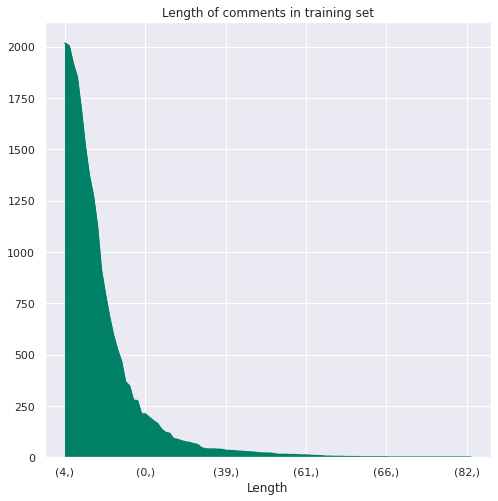

In [ ]:
length(preprocessed_train)

In [ ]:
X_train = preprocessed_train['free_text']
y_train = preprocessed_train['label_id'].values
X_dev = preprocessed_dev['free_text']
y_dev = preprocessed_dev['label_id'].values
X_test = preprocessed_test['free_text']
y_test = preprocessed_test['label_id'].values

In [ ]:
X_train = pd.concat([X_train, X_dev], ignore_index=True)
y_train = np.concatenate((y_train,y_dev),axis = 0)
# X_train = merge(X_train)
# X_test = merge(X_test)

##Word cloud

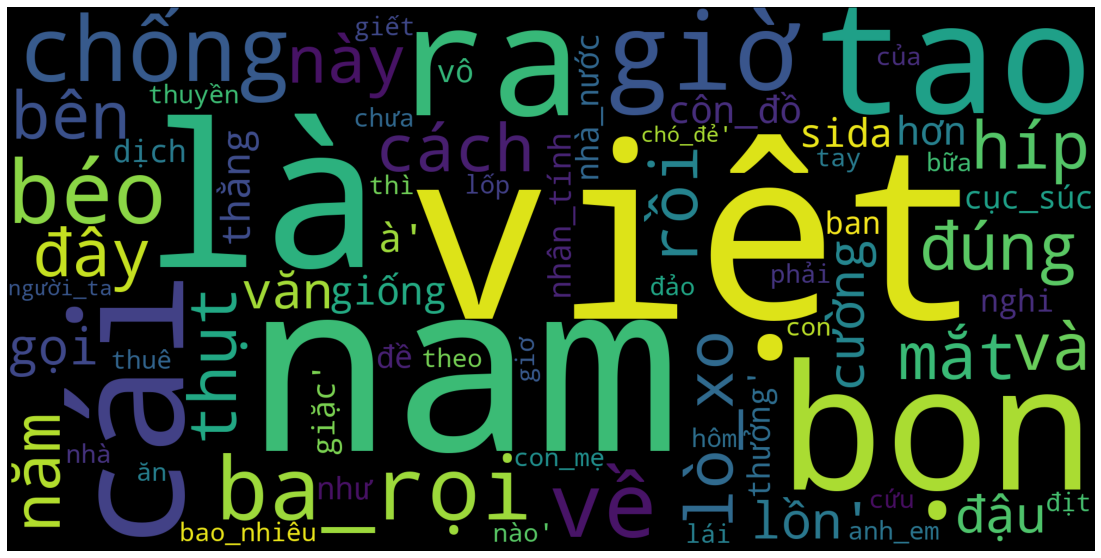

In [ ]:
import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
cloud = np.array(X_train).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

##ML

## TF-IDF

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=len(vocab))
X_train = Tfidf_vect.fit_transform(X_train.values.astype('U'))
X_test = Tfidf_vect.transform(X_test.values.astype('U'))
clf = LogisticRegression(C=10, penalty= 'l2').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9629    0.9087    0.9350      5879
           1     0.2995    0.5216    0.3805       255
           2     0.4840    0.6099    0.5397       546

    accuracy                         0.8695      6680
   macro avg     0.5821    0.6800    0.6184      6680
weighted avg     0.8984    0.8695    0.8815      6680



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# 0.61663026 0.87035928

## Find best hyperparameter

###LR

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import fbeta_score, make_scorer
# param_grid = {  'C': [ 0.1, 1, 10, 100,1000],
#               }
# clf = LogisticRegression()#class_weight = 'balanced')

# scoring =make_scorer(f1_score, average='macro')
# g_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                         cv = 5, 
#                         return_train_score=True,
#                         scoring = scoring
#                         )
# g_search.fit(X_train, y_train)

# print(g_search.best_params_)

###SVM

In [ ]:
# parameters = {'kernel':['linear', 'rbf'], 
#               'C':[1, 10, 100,1000,10000],
#               'gamma': [10,1, 0.1, 0.01, 0.001],
#               }
# svc = svm.SVC()
# scoring =make_scorer(f1_score, average='macro')
# g_search = GridSearchCV(svc, parameters,scoring=scoring,cv = 5, 
#                         # n_jobs = 1, 
#                         # verbose = 0, 
#                         return_train_score=True,)
# g_search.fit(X_train, y_train)
# print(g_search.best_params_)


##LR

In [ ]:
SVM = svm.SVC(C=100, kernel='rbf', gamma=0.01).fit(X_train, y_train)
y_pred = SVM.predict(X_test)
print(classification_report(y_pred, y_test, digits = 4))
# clf = LogisticRegression(C=10, penalty= 'l2').fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(classification_report(y_pred, y_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9728    0.9018    0.9359      5985
           1     0.2770    0.5748    0.3739       214
           2     0.4477    0.6403    0.5269       481

    accuracy                         0.8725      6680
   macro avg     0.5658    0.7056    0.6122      6680
weighted avg     0.9127    0.8725    0.8885      6680



##SVM

##Bert multi case

In [ ]:
X_train = tokenize_train['free_text']
y_train = tokenize_train['label_id'].values

X_dev = tokenize_dev['free_text']
y_dev = tokenize_dev['label_id'].values

X_test = tokenize_test['free_text']
y_test = tokenize_test['label_id'].values

In [ ]:
class BuildDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, X, y, max_len):
        self.tokenizer = tokenizer
        self.comment_text = X
        self.targets = y
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())
        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(self.targets[index], dtype=torch.long)
        }


In [ ]:
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1} 

In [ ]:
model_checkpoint = 'bert-base-multilingual-cased'
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
# Chuan bi data
MAX_LEN = 100
training_set = BuildDataset(tokenizer, X_train, y_train, max_len = MAX_LEN)
test_set = BuildDataset(tokenizer,  X_test, y_test, max_len = MAX_LEN)
dev_set = BuildDataset(tokenizer,  X_dev, y_dev, max_len = MAX_LEN)

In [ ]:
#  torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
# Chuan bi mo hinh
data_collator = DataCollatorWithPadding(tokenizer)
training_args = TrainingArguments(
    output_dir='/results',          
    num_train_epochs = 8,              
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    learning_rate = 1e-5,  
    warmup_steps=1000,   
    save_steps=1000,         
    weight_decay=0.01,
    logging_dir = '/logs',
    evaluation_strategy ='steps',
    eval_steps = 500,
    save_total_limit = 5,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,                         
    args=training_args, 
    data_collator =data_collator,                 
    train_dataset=training_set,         
    eval_dataset=dev_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

###Predict

In [ ]:
trainer.evaluate()
model_path = "multi-bert-base-cased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_path)
predictions, label_ids ,metrics =trainer.predict(test_set)
y_pred = np.argmax(predictions, axis=1)
print(classification_report( y_test, y_pred, digits = 4))

In [ ]:
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")#.to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return int(probs.argmax())
text = "thằng chó mất dạy, cmm nhá, vl, dmcs"
print(get_prediction(text))

##Bert multi uncased

In [ ]:
model_checkpoint = 'bert-base-multilingual-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
# Chuan bi data
MAX_LEN = 100
training_set = BuildDataset(tokenizer, X_train, y_train, max_len = MAX_LEN)
test_set = BuildDataset(tokenizer,  X_test, y_test, max_len = MAX_LEN)
dev_set = BuildDataset(tokenizer,  X_dev, y_dev, max_len = MAX_LEN)

In [ ]:
# Chuan bi mo hinh
data_collator = DataCollatorWithPadding(tokenizer)
training_args = TrainingArguments(
    output_dir='/results',          
    num_train_epochs = 8,              
    per_device_train_batch_size=64 ,
    per_device_eval_batch_size=32,
    learning_rate = 1e-5,  
    warmup_steps=1000,   
    save_steps=1000,         
    weight_decay=0.01,
    logging_dir = '/logs',
    evaluation_strategy ='steps',
    eval_steps = 500,
    save_total_limit = 5,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,                         
    args=training_args, 
    data_collator =data_collator,                 
    train_dataset=training_set,         
    eval_dataset=dev_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
trainer.train()

In [ ]:
trainer.evaluate()
model_path = "multi-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(model_path)
predictions, label_ids ,metrics =trainer.predict(test_set)
y_pred = np.argmax(predictions, axis=1)
print(f1_score(label_ids, y_pred, average='macro'))
print(accuracy_score(label_ids, y_pred))

In [ ]:
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")#.to("cuda")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    return int(probs.argmax())
text = "thằng chó mất dạy, cmm nhá, vl, dmcs"
print(get_prediction(text))

## h

In [ ]:
re.sub('[^!-~]+',' ','trời đang dần sáng @# !').strip()